## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tweepy
import us
import matplotlib.pyplot as plt
from adjustText import adjust_text

## Set library parameters

In [2]:
# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Pandas + matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Pyplot options
plt.rcParams.update({'font.size': 16, 'font.sans-serif': 'Arial'})

## Import data

Download Tweets from https://corona-tweets.datasettecloud.com/data/tweets?created_at__gte=2020-01-01T00%3A00%3A00%2B00%3A00 (check all options in Advanced download), which includes a `created_at ≥ 2020-01-01T00:00:00+00:00` filter

Data in this notebook were downloaded from the above link on 2020/03/26 ~11:30 AM PST and saved to the location in the variable `tweets`

In [3]:
tweets_sheet = '../data/source/tweets.csv'
df_tweets = pd.read_csv(tweets_sheet)
df_tweets.head()

/Users/ihwang/.local/share/virtualenvs/covid19-tweets-jKmwAzGh/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,user,user_label,created_at,full_text,retweeted_status,retweeted_status_label,quoted_status,quoted_status_label,place,place_label,source,source_label,truncated,display_text_range,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,geo,coordinates,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,scopes,withheld_in_countries
0,1212161689795407874,931187167811985409,Mayor Jenny Durkan,2020-01-01T00:00:42+00:00,"This year, we passed the #FareShare plan, establishing a fair wage for Uber and Lyft drivers, and investing millions of dollars in housing near transit and transportation projects - including the new Center City Connector Streetcar. https://twitter.com/MayorJenny/status/1212161689795407874/photo/1",NaN,NaN,NaN,NaN,NaN,NaN,717e7eefbc0846576be67629441f9328f889dd37,Falcon Social Media Management,0,"[0, 232]",NaN,NaN,NaN,NaN,NaN,NaN,0,0,4,0,0,en,0.0,NaN,NaN
1,1212161969337188352,279775962,nzoCALIFAmedia[um]ship,2020-01-01T00:01:49+00:00,A Grand salute to the visionary efforts of Stockton's Mayor @MichaelDTubbs and its dedicated citizens.🌿#peace #LOVE #unity https://twitter.com/MichaelDTubbs/status/1212159841201876993,NaN,NaN,1.212160e+18,1.212160e+18,NaN,NaN,1f89d6a41b1505a3071169f8d0d028ba9ad6f952,Twitter Web App,0,"[0, 122]",NaN,NaN,NaN,NaN,NaN,NaN,1,2,7,0,0,en,0.0,NaN,NaN
2,1212164552361566208,482708367,Michael Tubbs,2020-01-01T00:12:04+00:00,"In 2019, We spoke to @thenation about dignity and economic inclusion https://www.thenation.com/article/stockton-california-michael-tubbs-poverty-basic-income/",NaN,NaN,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 92]",NaN,NaN,NaN,NaN,NaN,NaN,0,2,22,0,0,en,0.0,NaN,NaN
3,1212165375888121856,2674399544,Mayor Q,2020-01-01T00:15:21+00:00,"@TonysKansasCity That was well written, T. Thank you.",NaN,NaN,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[17, 53]",1.212157e+18,13812712.0,TonysKansasCity,NaN,NaN,NaN,0,0,4,0,0,en,NaN,NaN,NaN
4,1212165752163205120,318509758,DHW,2020-01-01T00:16:50+00:00,"The Department of Health and Welfare will be closed tomorrow, Jan. 1, 2020, for New Year’s Day. We wish you and yours a Happy New Year!",NaN,NaN,NaN,NaN,NaN,NaN,95f3aaaddaa45937ac94765e0ddb68ba2be92d20,Twitter for iPhone,0,"[0, 135]",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,en,NaN,NaN,NaN


In [4]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70258 entries, 0 to 70257
Data columns (total 30 columns):
id                         70258 non-null int64
user                       70258 non-null int64
user_label                 70258 non-null object
created_at                 70258 non-null object
full_text                  70258 non-null object
retweeted_status           17782 non-null float64
retweeted_status_label     17782 non-null float64
quoted_status              5109 non-null float64
quoted_status_label        5109 non-null float64
place                      4045 non-null object
place_label                4045 non-null object
source                     70258 non-null object
source_label               70258 non-null object
truncated                  70258 non-null int64
display_text_range         70258 non-null object
in_reply_to_status_id      10815 non-null float64
in_reply_to_user_id        11412 non-null float64
in_reply_to_screen_name    11412 non-null object
geo       

Specify variables to download specific sheets from the official_twitter_handles Google Sheet
* Google Sheet document location: https://docs.google.com/spreadsheets/d/1tIt_kv0n1gUIFSmfQbp73LmEu6z81o4zKe65IT49Ru8
* GUIDs refer to the IDs of individual sheeets within the document

In [5]:
sheet_key = '1tIt_kv0n1gUIFSmfQbp73LmEu6z81o4zKe65IT49Ru8'
guid_dict = {
    'Healthcare':64630233,
    'Governers':470577166,
    'Congress': 354414704
}
guid = guid_dict['Healthcare']

In [6]:
handles_sheet = 'https://docs.google.com/spreadsheets/d/' + sheet_key + '/export?format=csv&gid=%s' %guid
df_hc_handles = pd.read_csv(handles_sheet)
df_hc_handles.head()
# df_hc_handles.info()

,State,Abbreviation,State Health Departments,Website,Twitter Handle,Covid Page,Covid Twitter Handle
0,Alabama,AL,Alabama Department of Public Health,http://www.alabamapublichealth.gov/,alpublichealth,NaN,NaN
1,Alaska,AK,Alaska Division of Public Health,http://dhss.alaska.gov/dph/Pages/default.aspx,Alaska_DHSS,NaN,NaN
2,Arizona,AZ,Arizona Department of Health Services,https://www.azdhs.gov/,azdhs,NaN,NaN
3,Arkansas,AR,Arkansas Department of Health,https://www.healthy.arkansas.gov/,adhpio,NaN,NaN
4,California,CA,California Department of Public Health,https://www.cdph.ca.gov/,CAPublicHealth,NaN,NaN


Read in Twitter credentials from .env file

In [7]:
twitter_creds = '../.env'

with open(twitter_creds) as f:
    for line in f:
        line_contents = line.strip().split('=')
        if line_contents[0] == 'CONSUMER_KEY':
            consumer_key = line_contents[1]
        elif line_contents[0] == 'CONSUMER_SECRET_KEY':
            consumer_secret = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN':
            access_token = line_contents[1]
        elif line_contents[0] == 'ACCESS_TOKEN_SECRET':
            access_token_secret = line_contents[1]
        else:
            pass

Access Twitter API

In [8]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

Get Twitter user IDs from handles

In [9]:
user_ids = [api.get_user(screen_name).id for screen_name in df_hc_handles['Twitter Handle']]

Get historical state cases data from The COVID Tracking Project (https://covidtracking.com/api/)

In [10]:
df_states_cases = pd.read_json('https://covidtracking.com/api/states/daily')
df_states_cases['dateChecked'] = pd.to_datetime(df_states_cases['dateChecked'])
df_states_cases['date'] = pd.to_datetime(df_states_cases['date'], format='%Y%m%d')
df_states_cases.head()

,date,dateChecked,death,deathIncrease,hospitalized,hospitalizedIncrease,negative,negativeIncrease,pending,positive,positiveIncrease,state,total,totalTestResults,totalTestResultsIncrease
0,2020-03-26,2020-03-26 20:00:00+00:00,1.0,0.0,3.0,2.0,1801.0,152.0,NaN,59.0,17.0,AK,1860,1860,169.0
1,2020-03-26,2020-03-26 20:00:00+00:00,1.0,1.0,NaN,0.0,3593.0,1064.0,NaN,506.0,223.0,AL,4099,4099,1287.0
2,2020-03-26,2020-03-26 20:00:00+00:00,3.0,1.0,41.0,19.0,1504.0,67.0,0.0,335.0,55.0,AR,1839,1839,122.0
3,2020-03-26,2020-03-26 20:00:00+00:00,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,AS,0,0,0.0
4,2020-03-26,2020-03-26 20:00:00+00:00,8.0,2.0,66.0,58.0,347.0,24.0,33.0,577.0,127.0,AZ,957,924,151.0


## Process raw data

Add Twitter user IDs to `df_handles` dataframe

In [11]:
df_hc_handles.set_index([user_ids], inplace=True);

Create `df_hc_tweets` dataframe and do some basic cleaning up on it.

In [12]:
# Join df_tweets and df_hc_handles to get dataframe of tweets from Healthcare agencies
df_hc_tweets = pd.merge(
    df_tweets, df_hc_handles, left_on='user', right_index=True, how='inner', sort=False
)
# Transform created_at column from Timestamp to DateTime object
df_hc_tweets['created_at'] = pd.to_datetime(df_hc_tweets['created_at'])

# df_hc_tweets.head()
df_hc_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13003 entries, 4 to 70032
Data columns (total 37 columns):
id                          13003 non-null int64
user                        13003 non-null int64
user_label                  13003 non-null object
created_at                  13003 non-null datetime64[ns, UTC]
full_text                   13003 non-null object
retweeted_status            4434 non-null float64
retweeted_status_label      4434 non-null float64
quoted_status               486 non-null float64
quoted_status_label         486 non-null float64
place                       109 non-null object
place_label                 109 non-null object
source                      13003 non-null object
source_label                13003 non-null object
truncated                   13003 non-null int64
display_text_range          13003 non-null object
in_reply_to_status_id       1652 non-null float64
in_reply_to_user_id         1741 non-null float64
in_reply_to_screen_name     1741 non-

Extract tweets from health departments mentioning COVID-19

In [13]:
# Filter for keywords coronavirus and covid (not case-sensitive)
df_hc_covid_tweets = df_hc_tweets[df_hc_tweets['full_text'].\
                                  str.contains('coronavirus|covid', regex=True, case=False)]

# df_hc_covid_tweets.head()
df_hc_covid_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5105 entries, 9850 to 70032
Data columns (total 37 columns):
id                          5105 non-null int64
user                        5105 non-null int64
user_label                  5105 non-null object
created_at                  5105 non-null datetime64[ns, UTC]
full_text                   5105 non-null object
retweeted_status            1583 non-null float64
retweeted_status_label      1583 non-null float64
quoted_status               161 non-null float64
quoted_status_label         161 non-null float64
place                       47 non-null object
place_label                 47 non-null object
source                      5105 non-null object
source_label                5105 non-null object
truncated                   5105 non-null int64
display_text_range          5105 non-null object
in_reply_to_status_id       590 non-null float64
in_reply_to_user_id         632 non-null float64
in_reply_to_screen_name     632 non-null object


## Basic questions

How much has each agency tweeted?

In [14]:
df_hc_covid_tweets['State Health Departments'].value_counts().sort_values(ascending=False)

North Carolina Department of Health and Human Services    395
Pennsylvania Department of Health                         342
Alabama Department of Public Health                       268
New Jersey Department of Health                           220
Oregon Health Authority                                   219
Minnesota Department of Health                            198
Illinois Department of Public Health                      185
Rhode Island Department of Health                         167
District of Columbia Department of Health                 157
Delaware Division of Public Health                        144
Tennessee Department of Health                            143
New York State Department of Health                       139
Idaho Department of Health and Welfare                    127
Oklahoma State Department of Health                       127
Ohio Department of Health                                 113
Washington Department of Health                           100
Indiana 

NOTE: wrong handle for South Carolina, should be SCDHEC, not cdhec (seemed suspiciously low, so checekd the handle). Drop cdhec from future analysis. REMOVE THIS AND FOLLOWING CELL WHEN HANDLES ARE UPDATED PROPERLY

In [15]:
df_hc_covid_tweets = df_hc_covid_tweets[df_hc_covid_tweets['Twitter Handle'] != 'cdhec']

When did healthcare departments start tweeting?

In [16]:
df_hc_covid_tweets.groupby('State Health Departments')['created_at'].min().sort_values(ascending=True)

State Health Departments
New Jersey Department of Health                          2020-01-17 19:32:00+00:00
Rhode Island Department of Health                        2020-01-17 20:38:45+00:00
Illinois Department of Public Health                     2020-01-21 20:45:20+00:00
New York State Department of Health                      2020-01-21 20:48:15+00:00
Minnesota Department of Health                           2020-01-21 21:24:27+00:00
North Dakota Department of Health                        2020-01-21 22:22:28+00:00
Oregon Health Authority                                  2020-01-22 18:10:38+00:00
Vermont Department of Health                             2020-01-22 18:18:14+00:00
Idaho Department of Health and Welfare                   2020-01-22 19:49:38+00:00
Alabama Department of Public Health                      2020-01-22 21:42:27+00:00
Alaska Division of Public Health                         2020-01-23 00:38:03+00:00
Missouri Department of Health and Senior Services        2020-

## Visualizations

Plot cumulative number of Tweets, positive cases, hospitalizations and deaths over time

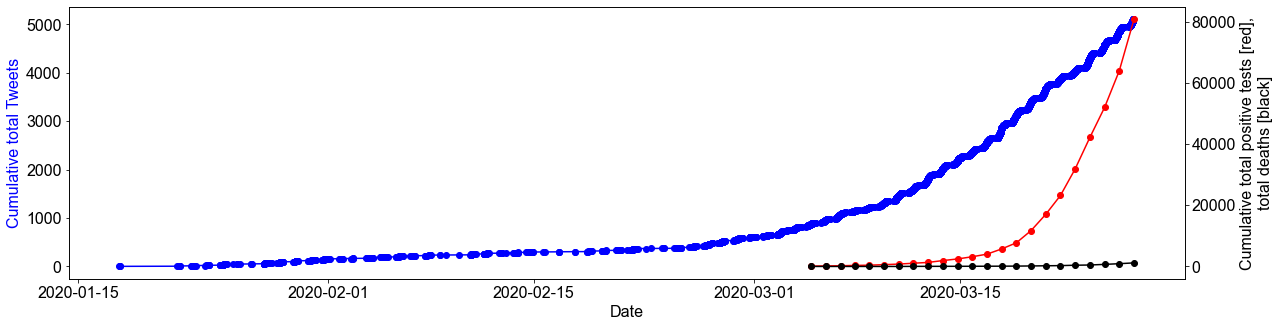

In [17]:
# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()
series_pos = df_states_cases.groupby('dateChecked')['positive'].sum()
series_deaths = df_states_cases.groupby('dateChecked')['death'].sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')
axes2.plot(series_pos.index, series_pos, 'o-', color='red')
axes2.plot(series_deaths.index, series_deaths, 'o-', color='black')
axes.set_ylabel('Cumulative total Tweets', color='blue')
axes2.set_ylabel('Cumulative total positive tests [red],\ntotal deaths [black]')
axes.set_xlabel('Date')
plt.show()

Show total Tweets and Tweets for each state

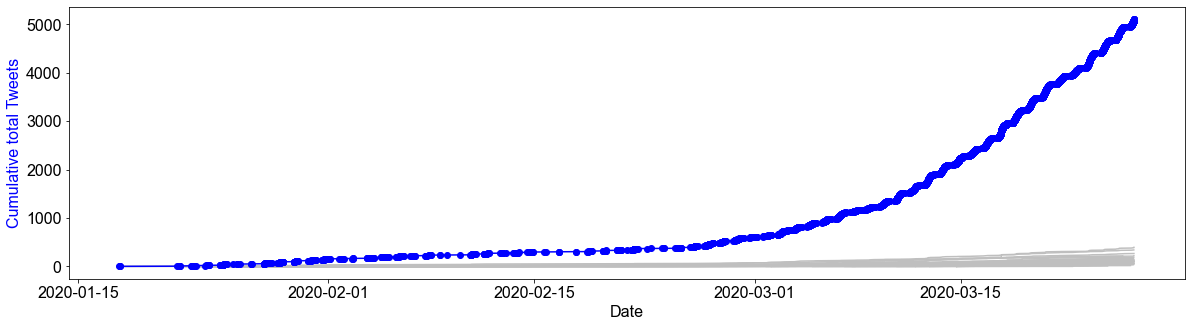

In [18]:
# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))

state_depts = df_hc_covid_tweets['State Health Departments'].unique()

for state in state_depts:
    df_state = df_hc_covid_tweets[df_hc_covid_tweets['State Health Departments'] == state]
    df_state = df_state.sort_values('created_at').reset_index()
    axes.plot(df_state['created_at'], df_state.index, '-', color='0.75')
axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')

axes.set_ylabel('Cumulative total Tweets', color='blue')
axes.set_xlabel('Date')
plt.show()

It's hard to tell with total Tweets, so let's plot just individual states, with the ability to highlight one state of interest

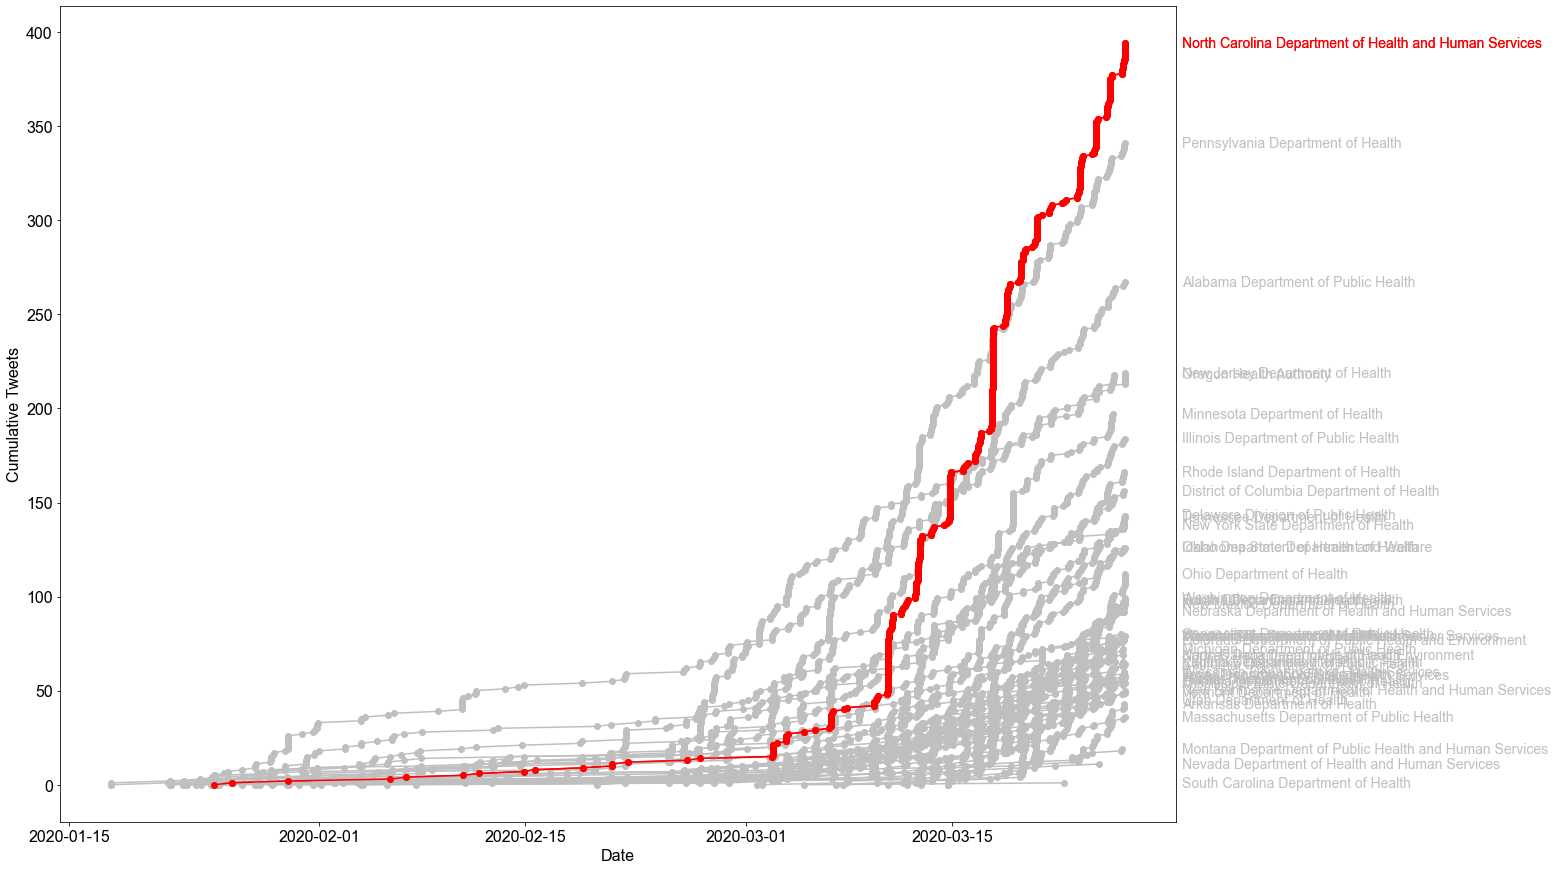

In [30]:
state = 'NC'
dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Departments'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets.sort_values('created_at').reset_index()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 15))

state_depts = df_hc_covid_tweets['State Health Departments'].unique()
state_depts = np.append(np.delete(state_depts, np.argwhere(state_depts=='Hawaii Department of Health')[0][0]), dept)

for state_dept in state_depts:
    df_state = df_hc_covid_tweets[df_hc_covid_tweets['State Health Departments'] == state_dept]
    df_state = df_state.sort_values('created_at').reset_index()
    if state_dept == dept:
        color = 'red'
    else:
        color = '0.75'
    axes.plot(df_state['created_at'], df_state.index, 'o-', color=color)

for line, name in zip(axes.lines, state_depts):
    y = line.get_ydata()[-1]
    if name == dept:
        color = 'red'
    else:
        color = '0.75'
    axes.annotate(name, xy=(1,y), xytext=(6,0), color=color,
                xycoords = axes.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")

axes.set_ylabel('Cumulative Tweets')
axes.set_xlabel('Date')
plt.show()

Tweets per state department vs. positive tests, hospitalizations and deaths


OUTSTANDING QUESTIONS
* How to normalize the above? Population? Number of tweets over time?

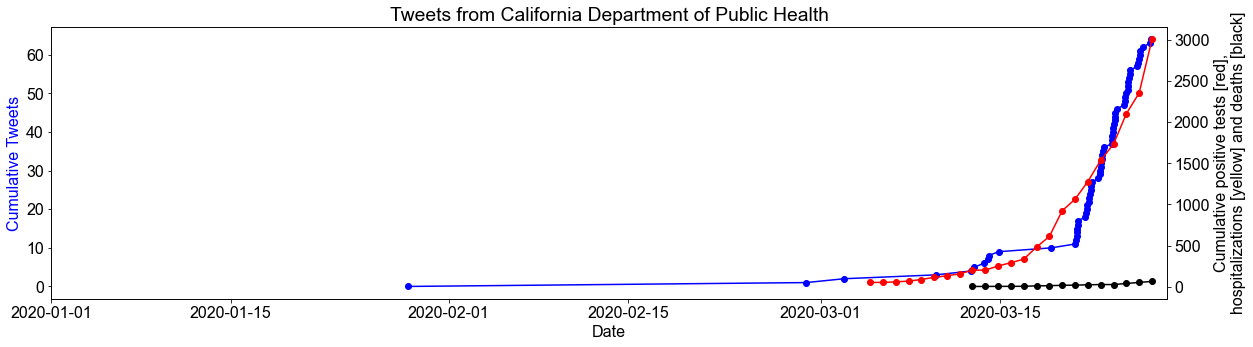

In [20]:
state = 'CA'

dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Departments'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Departments'] == dept]
df_plot = df_plot.sort_values('created_at').reset_index()
df_state = df_states_cases[df_states_cases['state'] == state]

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(df_plot['created_at'], df_plot.index, 'o-', color='blue')
axes2.plot(df_state['dateChecked'], df_state['positive'], 'o-', color='red')
axes2.plot(df_state['dateChecked'], df_state['death'], 'o-', color='black')
axes2.plot(df_state['dateChecked'], df_state['hospitalized'], 'o-', color='yellow')
axes.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-03-28'))
axes.set_title('Tweets from the %sm\n and cases in ' %dept)
axes.set_ylabel('Cumulative Tweets', color='blue')
axes2.set_ylabel('Cumulative positive tests [red],\nhospitalizations [yellow] and deaths [black]')
axes.set_xlabel('Date')
plt.show()

* Retweeets. For each day check number of total number of retweets on posts from account, and also number of posts that were retweets of other accounts

Top accounts this account engaged with?

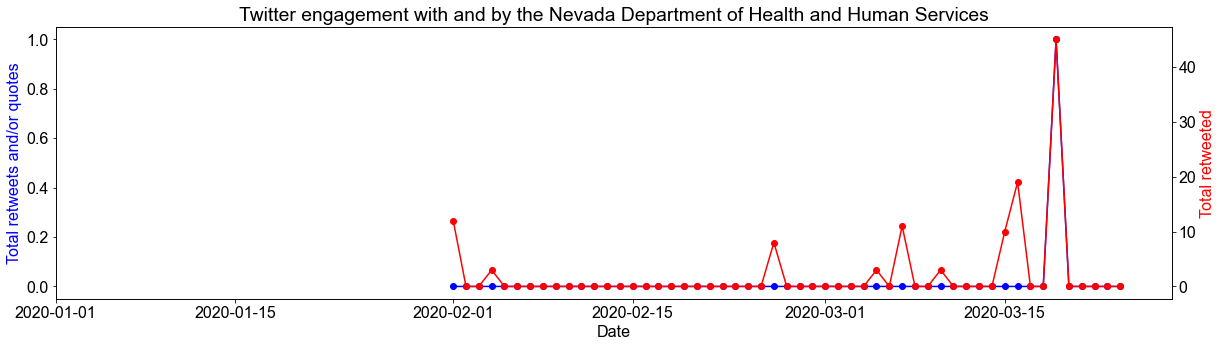

In [29]:
state = 'NV'

dept = df_hc_handles[df_hc_handles['Abbreviation'] == state]['State Health Departments'].iloc[0]

# Define df
df_plot = df_hc_covid_tweets[df_hc_covid_tweets['State Health Departments'] == dept]
df_engaged_with_counts = df_plot[['created_at', 'retweeted_status', 'quoted_status']].resample('D', on='created_at').count()
series_engaged_with = df_engaged_with_counts.drop(columns=['created_at']).sum(axis=1)
df_engaged_by = df_plot[['created_at', 'retweet_count']].resample('D', on='created_at').sum()

# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(20, 5))
axes2 = axes.twinx()

axes.plot(series_engaged_with.index, series_engaged_with, 'o-', color='blue')
axes2.plot(df_engaged_by.index, df_engaged_by['retweet_count'], 'o-', color='red')

axes.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-03-28'))
axes.set_title('Twitter engagement with and by the %s' %dept)
axes.set_ylabel('Total retweets and/or quotes', color='blue')
axes2.set_ylabel('Total retweeted', color='red')
axes.set_xlabel('Date')
plt.show()

* test results?